In [68]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
from matplotlib.finance import fetch_historical_yahoo, parse_yahoo_historical_ochl
import pandas_datareader as pdr

In [69]:
def evaluate_stationarity(timeseries, t=30):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
    'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [70]:
start = datetime(1970, 1, 1)
end = datetime(2017, 10, 20)
ts = pdr.get_data_yahoo("EURUSD=X", start, end)
#yahoo_data = parse_yahoo_historical_ochl(fh, asobject=True, adjusted=False)

In [71]:
ts.Close.fillna(method='ffill',inplace=True)

In [72]:
data_log=np.log(ts.Close)

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  if __name__ == '__main__':


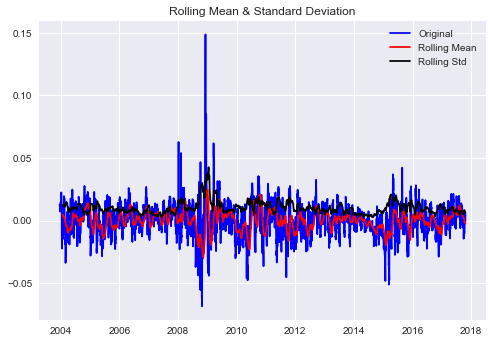

Results of Dickey-Fuller Test:
Test Statistic                -1.080861e+01
p-value                        1.934442e-19
#Lags Used                     2.300000e+01
Number of Observations Used    3.587000e+03
Critical Value (5%)           -2.862346e+00
Critical Value (1%)           -3.432174e+00
Critical Value (10%)          -2.567199e+00
dtype: float64


In [73]:
moving_avg = pd.rolling_mean(data_log, window=15)
data_log_diff = data_log - moving_avg
evaluate_stationarity(data_log_diff.dropna())

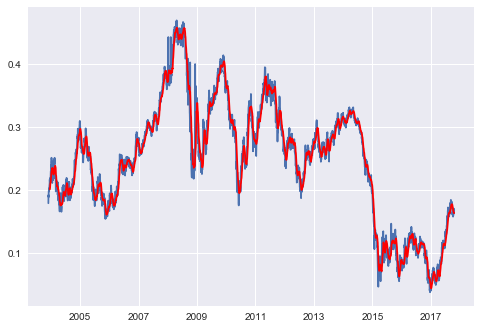

In [74]:
plt.plot(data_log)
plt.plot(moving_avg, color='red')
plt.show()

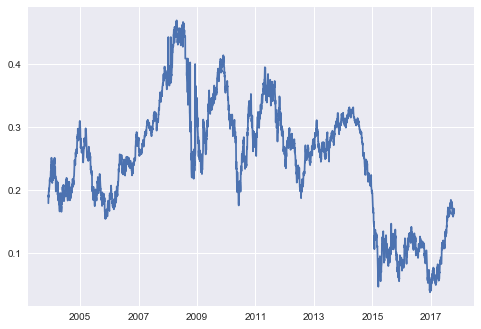

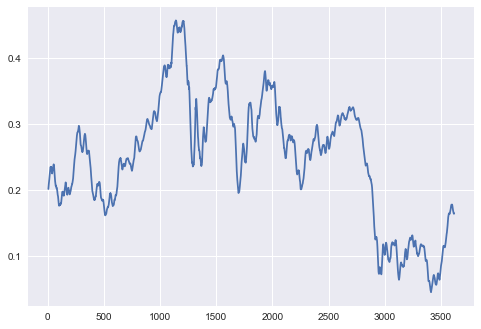

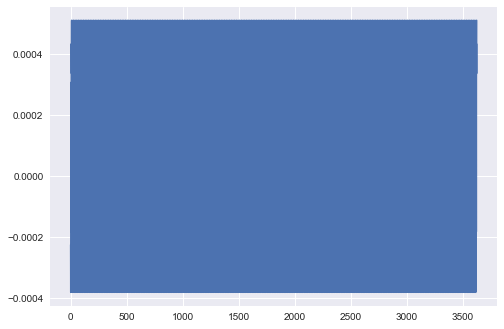

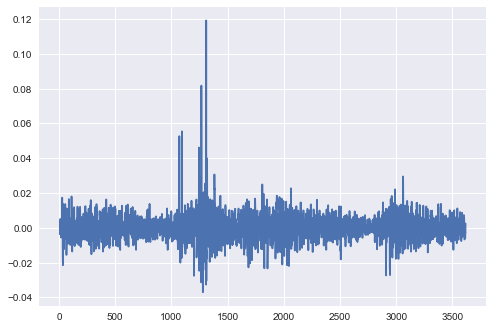

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_log), freq=15)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(data_log, label='Original')
plt.show()
plt.legend(loc='best')
plt.plot(trend, label='Trend')
plt.show()
plt.legend(loc='best')
plt.plot(seasonal,label='Seasonality')
plt.show()
plt.plot(residual,label='Noise')
plt.show()

In [76]:
#time sereis manipulation
Open = ts.Open
Open.fillna(method='ffill',inplace=True)

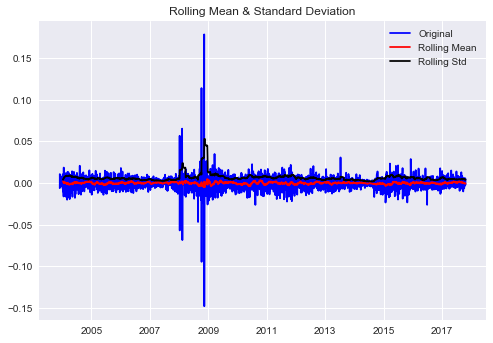

Results of Dickey-Fuller Test:
Test Statistic                -1.083126e+01
p-value                        1.705756e-19
#Lags Used                     2.800000e+01
Number of Observations Used    3.595000e+03
Critical Value (5%)           -2.862344e+00
Critical Value (1%)           -3.432170e+00
Critical Value (10%)          -2.567198e+00
dtype: float64


In [77]:
evaluate_stationarity(Open.pct_change().dropna())

In [78]:
ret =Open.pct_change().shift(-1)

In [106]:
def create_lag_df(ts,lag,mean_lag=10):
    df = pd.DataFrame()
    ts = ts.pct_change()
    df['ret'] = ts.shift(-1)
    #s = Open.pct_change()
    for i in range(lag,0,-1):
        df['t_'+str(i)] = ts.shift(i)
    df['t'] = ts.values
    df = df[(lag+1):]
    df['Rolling_Mean'] = pd.rolling_mean(ts,window=mean_lag)
    
    print(df.head())
    return df

In [107]:
df = create_lag_df(ts.Open,lag=10)

                 ret      t_10       t_9       t_8       t_7       t_6  \
Date                                                                     
2003-12-16  0.000480 -0.006064  0.010784  0.002485 -0.003467  0.009019   
2003-12-17  0.006660  0.010784  0.002485 -0.003467  0.009019  0.002798   
2003-12-18  0.001615  0.002485 -0.003467  0.009019  0.002798  0.002291   
2003-12-19 -0.002985 -0.003467  0.009019  0.002798  0.002291 -0.004742   
2003-12-22  0.001129  0.009019  0.002798  0.002291 -0.004742  0.002959   

                 t_5       t_4       t_3       t_2       t_1         t  \
Date                                                                     
2003-12-16  0.002798  0.002291 -0.004742  0.002959  0.004249  0.002857   
2003-12-17  0.002291 -0.004742  0.002959  0.004249  0.002857  0.000480   
2003-12-18 -0.004742  0.002959  0.004249  0.002857  0.000480  0.006660   
2003-12-19  0.002959  0.004249  0.002857  0.000480  0.006660  0.001615   
2003-12-22  0.004249  0.002857  0.000

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


In [108]:
#artificial features
#osscilator
def MACD(df, n_fast, n_slow):  
    EMAfast = pd.Series(pd.ewma(df, span = n_fast, min_periods = n_slow - 1))  
    EMAslow = pd.Series(pd.ewma(df, span = n_slow, min_periods = n_slow - 1))  
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))  
    MACDsign = pd.Series(pd.ewma(MACD, span = 9, min_periods = 8), name = 'MACDsign_' + str(n_fast) + '_' + str(n_slow))  
    MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))  
    df = pd.concat([df,MACD,MACDsign,MACDdiff],axis=1)
    return df

#on balance volume
def OBV(df, n):  
    i = 0  
    OBV = [0]  
    while i < df.index[-1]:  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') > 0:  
            OBV.append(df.get_value(i + 1, 'Volume'))  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') == 0:  
            OBV.append(0)  
        if df.get_value(i + 1, 'Close') - df.get_value(i, 'Close') < 0:  
            OBV.append(-df.get_value(i + 1, 'Volume'))  
        i = i + 1  
    OBV = pd.Series(OBV)  
    OBV_ma = pd.Series(pd.rolling_mean(OBV, n), name = 'OBV_' + str(n))  
    df = pd.concat([df,OBV_ma],axis=1) 
    return df

def BBANDS(df, n):  
    MA = pd.Series(pd.rolling_mean(df, n))  
    MSD = pd.Series(pd.rolling_std(df, n))  
    b1 = 4 * MSD / MA  
    B1 = pd.Series(b1, name = 'BollingerB_' + str(n))  
    #df = pd.concat([df,B1],axis=1)
    b2 = (df - MA + 2 * MSD) / (4 * MSD)  
    B2 = pd.Series(b2, name = 'Bollinger%b_' + str(n))  
    df = pd.concat([df,B1,B2],axis=1)
    return df

def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i + 1 <= df.index[-1]:  
        UpMove = df.get_value(i + 1, 'High') - df.get_value(i, 'High')  
        DoMove = df.get_value(i, 'Low') - df.get_value(i + 1, 'Low')  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI)  
    PosDI = pd.Series(pd.ewma(UpI, span = n, min_periods = n - 1))  
    NegDI = pd.Series(pd.ewma(DoI, span = n, min_periods = n - 1))  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))  
    df = df.join(RSI)  
    return df

def STDDEV(df, n):  
    df = pd.concat([df,pd.Series(pd.rolling_std(df, n), name = 'STD_' + str(n))],axis=1)
    return df  

In [109]:
#https://www.thebalance.com/best-technical-indicators-for-day-trading-1031208
#https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

In [110]:
BBANDS(ts.Open,20)

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()


,Open,BollingerB_20,Bollinger%b_20
Date,,,
2003-12-01,1.203398,NaN,NaN
2003-12-02,1.196101,NaN,NaN
2003-12-03,1.209000,NaN,NaN
2003-12-04,1.212004,NaN,NaN
2003-12-05,1.207802,NaN,NaN
2003-12-08,1.218695,NaN,NaN
2003-12-09,1.222105,NaN,NaN
2003-12-10,1.224905,NaN,NaN
2003-12-11,1.219096,NaN,NaN


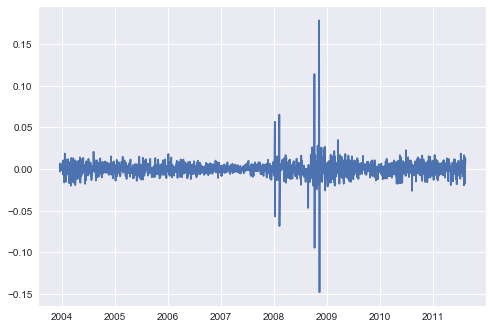

In [111]:
plt.plot(df.ret[:2000])
plt.show()

In [112]:

# pd.pivot_table(df,index=["Manager","Rep","Product"],
#                values=["Price","Quantity"],aggfunc=[np.sum],fill_value=0)

In [113]:
#feature extraction from time data
from dateutil.parser import parse

def create_time_columns(ts):
    col_names = ['DOM','DOW','Month',"Year"]
    times = ts.index.values
    l = []
    for t in times:
        t = parse(str(t))
        info = (t.day,t.weekday(),t.month,t.year)
        l.append(info)
    return pd.DataFrame(index=ts.index,data=l,columns=col_names)
    


In [114]:
df_new= pd.concat([df,create_time_columns(df.ret)],axis=1)

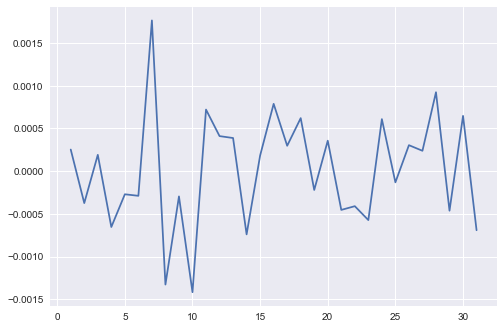

In [115]:
plt.plot(pd.pivot_table(df_new,index=["DOM"],
               values=["ret"],aggfunc=[np.mean],fill_value=0))
plt.show()

In [116]:
###
import operator
import itertools
import numpy as np
import pandas as pd
#from ggplot import *
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
#from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score

In [130]:
X =df_new.loc[:,('t','t_1','t_2','t_3','t_4','Rolling_Mean','DOM','DOW',"Month")]

In [131]:
Y = df_new.ret

In [132]:
Y = Y.iloc[:-1]
X = X.iloc[:-1,:]

In [120]:
####feature selectoin
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator, step=1)
selector = selector.fit(X, Y)
selector.support_ 
X=X.iloc[:,selector.support_ ]

In [121]:
#normalize/standarlize features
from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X)
#X = X.apply(lambda x:scaler.transform(x),axis=1)
X = X.apply(lambda x:preprocessing.normalize(x, norm='l2'),axis=1)
#X= preprocessing.normalize(X, norm='l2')
#X.values = scaler.transform(X)  \

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anacon

Exception: Data must be 1-dimensional

In [ ]:
X.skew(),Y.skew()

In [122]:
#skewness
def sk(df):
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: (x.dropna()).skew()).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print skewness.head(20)
    skewness = skewness[abs(skewness) > 0.5]
    print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.1
    for feat in skewed_features:
        #all_data[feat] += 1
        #df[feat] = boxcox1p(df[feat], lam)
        df[feat] = np.log1p(df[feat])
    

In [123]:
#Y.values = preprocessing.normalize(Y.values, norm='l2')
Y = np.log1p(Y)

In [124]:
Y.skew()

0.22762169209401173

In [125]:
sk(X)


Skew in numerical features: 

                  Skew
t             1.585574
t_3           1.584697
t_2           1.584673
Rolling_Mean  0.025829
There are 4 skewed numerical features to Box Cox transform


In [126]:
X.skew()

t               0.227809
t_2             0.227079
t_3             0.227252
Rolling_Mean    0.003777
dtype: float64

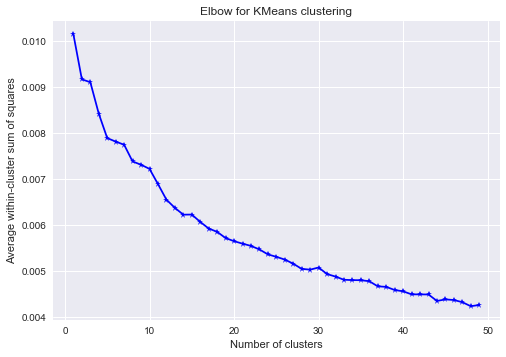

In [41]:
###unsupervised:decide how many clusters to use elbow
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

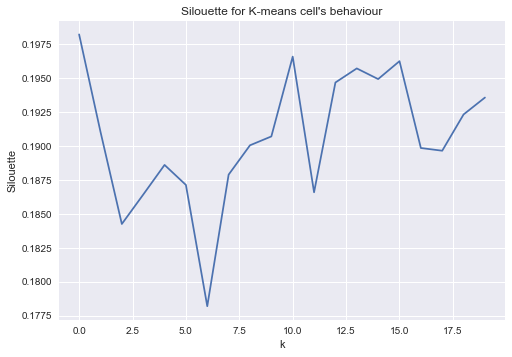

In [42]:
#################silouette score
s = []
for n_clusters in range(30,50):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(X, labels, metric='euclidean'))
plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
plt.show()

In [43]:
np.argmax(s)

0

In [141]:
cluster = KMeans(n_clusters = 15, random_state = 2)
X['cluster'] = cluster.fit_predict(X)
X.cluster.value_counts()

2     297
14    293
8     291
5     289
3     286
9     285
4     277
7     261
10    259
11    237
12    216
13    204
6     161
1     130
0     127
Name: cluster, dtype: int64

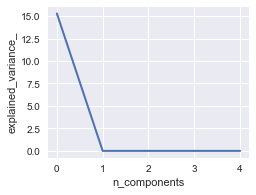

ValueError: n_components=10 must be between 0 and n_features=5 with svd_solver='full'

In [45]:
####PCA analysis
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

en = linear_model.ElasticNet()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('enet', en)])

# Plot the PCA spectrum
pca.fit(X.iloc[:-1,:])

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

# Prediction
n_components = [ 2, 5,10]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(X.iloc[:-1,:].values,Y[:-1])

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [142]:
combined = pd.concat([X,Y],axis=1)

In [47]:
#build a single time seresi regression model
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
X_train, X_test, y_train, y_test = train_test_split(
      X, Y, test_size=0.33, random_state=42)
model_lgb.fit(X_train.values, y_train.values)
lgb_train_pred = model_lgb.predict(X_train.values)
#lgb_pred = np.exp(lgb_train_pred)-1
print np.sqrt(mean_squared_error(y_train.values, lgb_train_pred))

OSError: dlopen(/anaconda2/lib/python2.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/7/libgomp.1.dylib
  Referenced from: /anaconda2/lib/python2.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

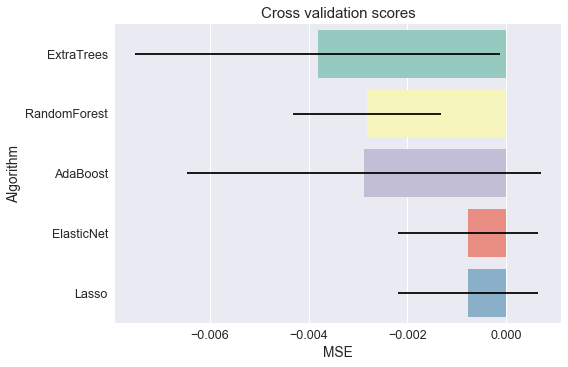

In [660]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV,Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
Regressors = []
Regressors.append(ExtraTreesRegressor(random_state=random_state))
Regressors.append(RandomForestRegressor(random_state=random_state))
Regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state),random_state=random_state,learning_rate=0.1))
Regressors.append(ElasticNet(random_state=random_state))
#Regressors.append(KernelRidge())
Regressors.append(Lasso(random_state=random_state))

cv_results = []
for Regressor in Regressors :
    cv_results.append(cross_val_score(Regressor,X_train.values, y = y_train.values, scoring = "mean_absolute_error", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["ExtraTrees","RandomForest","AdaBoost",
"ElasticNet","Lasso"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("MSE")
g = g.set_title("Cross validation scores")
plt.show()

In [661]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from vecstack import stacking
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

models = [
#     ExtraTreesRegressor(random_state = 0, n_jobs = 2, 
#         n_estimators = 100, max_depth = 3),
    
#     Pipeline([
#       ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
#       ('regression',randomForestRegressor(random_state = 0, n_jobs = 2, 
#         n_estimators = 100, max_depth = 3))
#     ]),
    
#      make_pipeline(SelectFromModel(ExtraTreesRegressor(random_state = 0, n_jobs = 2, n_estimators = 500, max_depth = 3)),RandomForestRegressor(random_state = 0, n_jobs = 2, 
#          n_estimators = 100, max_depth = 3)),
        
    lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2000,
                              max_bin = 60, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),
    
    make_pipeline(RobustScaler(), LassoCV(alphas =[0.0005,0.001,0.0015], random_state=1,cv=3)),
    make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),

    GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5),
    
    ]

# Compute stacking features
S_train, S_test = stacking(models, X_train.values, y_train.values, X_test.values, 
    regression = True, metric = mean_absolute_error, n_folds = 10, 
    shuffle = True, random_state = 0, verbose = 2)

model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0001, l1_ratio=.9, random_state=3))

#model = RandomForestRegressor(random_state = 0, n_jobs = 2, n_estimators = 1000, max_depth = 3)
    
# Fit 2-nd level model
model = model.fit(S_train, y_train.values)

# Predict
y_pred = model.predict(S_train)

# Final prediction score
print('Final prediction score: [%.8f]' % mean_absolute_error(y_train.values, y_pred))
y_pred = model.predict(S_test)
print('Final score: [%.8f]' % mean_absolute_error(y_test.values, y_pred))

task:   [regression]
metric: [mean_absolute_error]

model 0: [LGBMRegressor]
    fold 0: [0.00467790]
    fold 1: [0.00528891]
    fold 2: [0.00515592]
    fold 3: [0.00462823]
    fold 4: [0.00493737]
    fold 5: [0.00527032]
    fold 6: [0.00459932]
    fold 7: [0.00493826]
    fold 8: [0.00456098]
    fold 9: [0.00540108]
    ----
    MEAN:   [0.00494583]

model 1: [Pipeline]
    fold 0: [0.00476935]
    fold 1: [0.00530767]
    fold 2: [0.00499894]
    fold 3: [0.00469619]
    fold 4: [0.00529032]
    fold 5: [0.00525694]
    fold 6: [0.00475258]
    fold 7: [0.00493044]
    fold 8: [0.00459677]
    fold 9: [0.00566874]
    ----
    MEAN:   [0.00502680]

model 2: [Pipeline]
    fold 0: [0.00477325]
    fold 1: [0.00522979]
    fold 2: [0.00500003]
    fold 3: [0.00469934]
    fold 4: [0.00530118]
    fold 5: [0.00525778]
    fold 6: [0.00475916]
    fold 7: [0.00493248]
    fold 8: [0.00460015]
    fold 9: [0.00567665]
    ----
    MEAN:   [0.00502298]

model 3: [KernelRidge]
    f

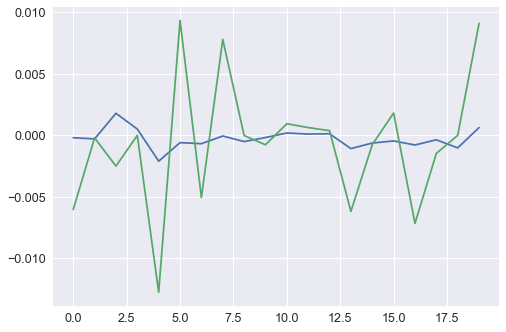

In [662]:
plt.plot(y_pred[:20])
plt.plot(y_test.values[:20])
plt.show()

In [663]:
prediction = [1 if x >0 else 0 for x in y_pred]
actual = [1 if x >0 else 0 for x in y_test]

In [664]:
from sklearn import metrics
print(metrics.classification_report(prediction, actual))
print metrics.confusion_matrix(prediction,actual)

             precision    recall  f1-score   support

          0       0.72      0.53      0.61       804
          1       0.37      0.56      0.45       389

avg / total       0.60      0.54      0.56      1193

[[430 374]
 [170 219]]


In [551]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


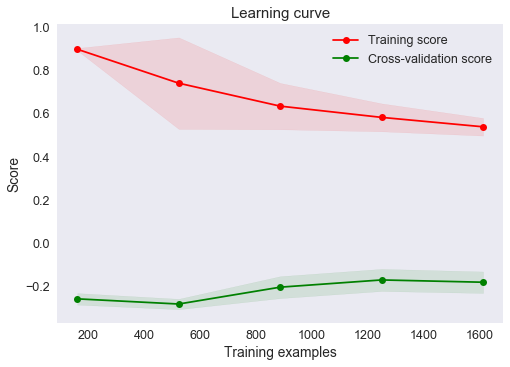

In [665]:
plot_learning_curve(models[4],"Learning curve",X_train.values,y_train.values)
plt.show()

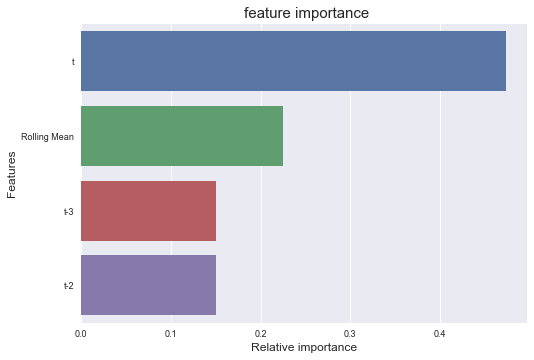

In [666]:
model = Regressors[2]
model.fit(X_train,y_train)
indices = np.argsort(model.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_train.columns[indices][:40],x = model.feature_importances_[indices][:40] ,orient='h')
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" feature importance")
y_pred = model.predict(X_train)
plt.show()

In [667]:
X_train.columns

Index([u't', u't-2', u't-3', u'Rolling Mean'], dtype='object')

In [567]:
def bivariate(df,target):
    target_type = df[target].dtype
    for col in df.columns:
        if col != target:
            col_type = df[col].dtype
            print (target,col)
            if col_type == 'object' and target_type == 'object':
                sns.countplot(y=target,hue=col,data=df)
                print "D_D"
            elif col_type != 'object' and target_type == 'object':
                sns.barplot(y=col,x=target,data=df)
                plt.show()
                sns.boxplot(y=col,x=target,data=df)
                print "C_D"
            elif col_type == 'object' and target_type != 'object':
                sns.barplot(y=target,x=col,data=df)
                plt.show()
                sns.boxplot(y=target,x=col,data=df)
                print "D_C"
            else:
                sns.jointplot(y=target,x=col,data=df)
                print "C_C"
            plt.show()

('ret', 't')
C_C


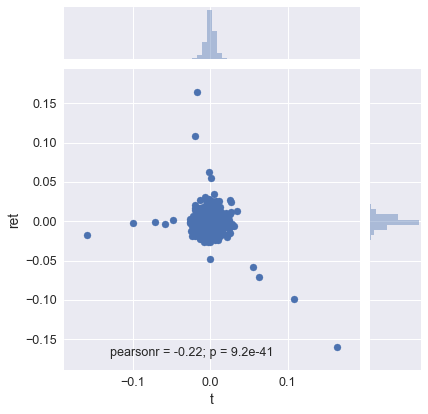

('ret', 't-1')
C_C


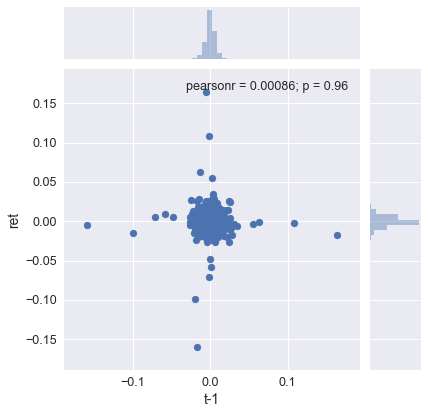

('ret', 't-2')
C_C


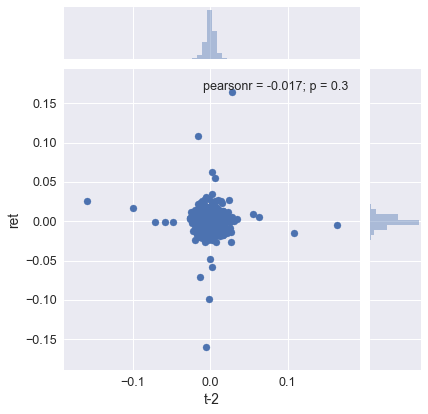

('ret', 't-3')
C_C


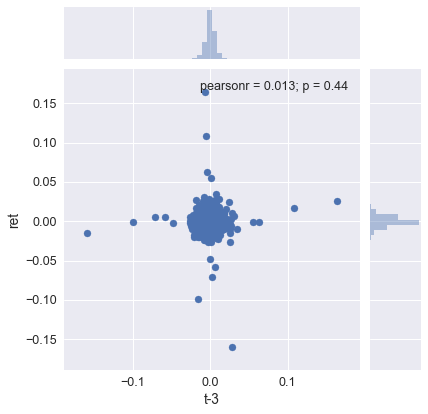

('ret', 't-4')
C_C


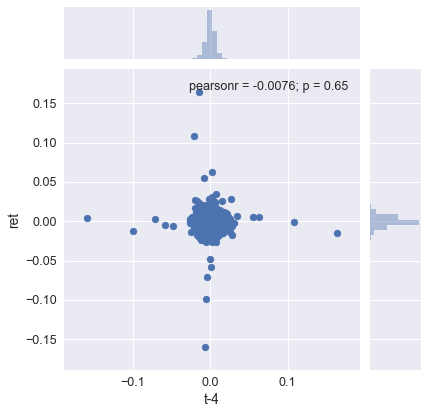

('ret', 'Rolling Mean')
C_C


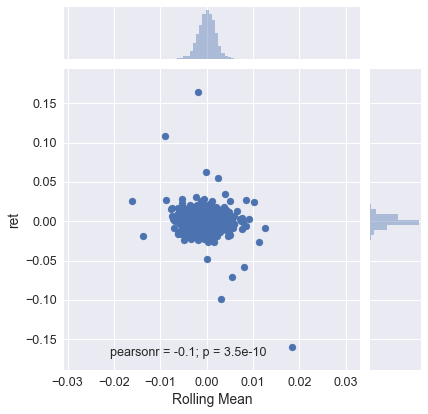

('ret', 'DOM')
C_C


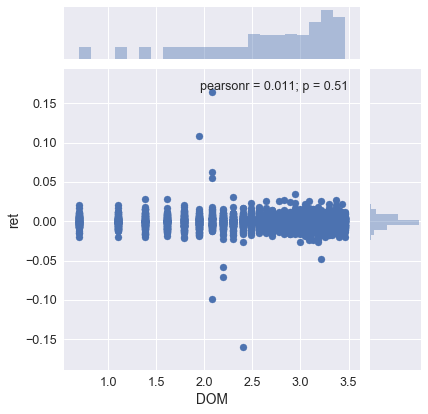

('ret', 'DOW')
C_C


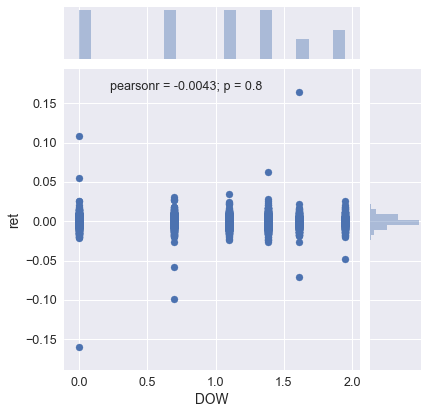

('ret', 'Month')
C_C


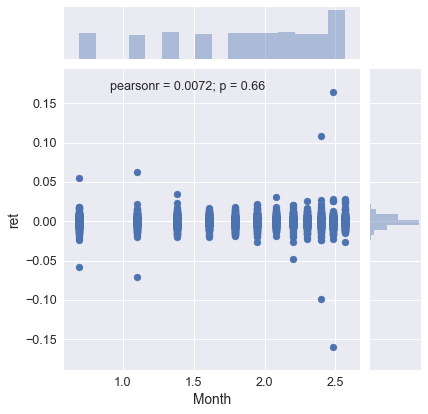

In [668]:
bivariate(combined,'ret')

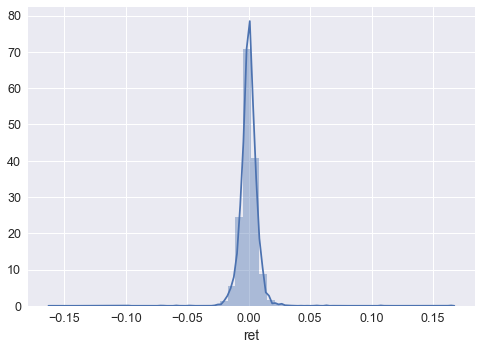

In [669]:
sns.distplot(combined.ret)
plt.show()
a,b = pd.qcut(combined["ret"],2,labels =['0','1'],retbins=True)
#a = np.array(a)

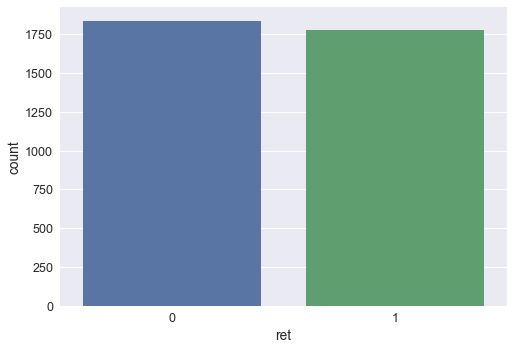

In [670]:
sns.countplot(a)
plt.show()

In [145]:
#https://towardsdatascience.com/how-to-create-new-features-using-clustering-4ae772387290
import statsmodels.api as sm

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     20.56
Date:                Wed, 20 Dec 2017   Prob (F-statistic):           1.52e-37
Time:                        23:16:35   Log-Likelihood:                 12383.
No. Observations:                3613   AIC:                        -2.475e+04
Df Residuals:                    3603   BIC:                        -2.468e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
t               -0.2312      0.019    -12.124      0.000      -0.269      -0.194
t_1             -0.0569      0.020     -2.881      0.004      -0.096      -0.018
t_2             -0.0245      0.020     -1.254      0.210      -0.063       0.014
t_3              0.0063      0.019      0.329      0.742      -0.031       0.044
t_4             -0.0047      0.018     -0.262      0.794      -0.040       0.031
Rolling_Mean    -0.0377      0.092     -0.411      0.681      -0.218       0.142
DOM          -1.566e-05   1.75e-05     -0.895      0.371      -5e-05    1.86e-05
DOW          -3.742e-05   6.56e-05     -0.570      0.568      -0.000    9.12e-05
Month        -7.348e-06   3.09e-05     -0.238      0.812   -6.79e-05    5.32e-05
cluster       6.461e-05   3.49e-05      1.854      0.064   -3.73e-06       0.000
==============================================================================
Omnibus:                     3001.017   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1263884.493
Skew:                           2.912   Prob(JB):                         0.00
Kurtosis:                      94.442   Cond. No.                     1.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [143]:
foward_model = forward_selected(combined,'ret')

In [144]:
print foward_model.model.formula
# sl ~ rk + yr + 1

print model.rsquared_adj
# 0.835190760538

ret ~ t + t_1 + cluster + t_2 + 1
0.0491219004631
